# Application 

Apply changepoint detection to the log-returns time series. 
I'd use the residuals from the VAR model.fit even tho apparently they are t-stud distributed and not normally distributed...


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('VAR_Residuals_BIC_leg1', index_col=0)
df.head()

,BNP FP Equity,CA FP Equity,CRH ID Equity,DAI GR Equity,BN FP Equity,DBK GR Equity,DTE GR Equity,ENEL IM Equity,ENGI FP Equity,ENI IM Equity,...,ABI BB Equity,MTS SM Equity,ASML NA Equity,G IM Equity,CS FP Equity,BBVA SM Equity,SAN SM Equity,BAS GR Equity,BAYN GR Equity,BMW GR Equity
2018-01-02 08:02:00,-0.000809,0.000705,-0.001358,0.000819,-0.000848,0.000179,-0.000897,0.000956,-0.000702,0.001029,...,-0.000251,-0.000347,-0.002149,0.000935,0.000804,0.000291,-0.001199,-0.000670,0.000337,0.003429
2018-01-02 08:03:00,-0.001502,0.000514,-0.001186,-0.000573,0.000311,-0.000111,-0.001569,0.000929,0.000240,0.001426,...,0.000108,0.002761,0.001257,0.000008,-0.000332,0.000186,0.001212,-0.000402,-0.000739,-0.001635
2018-01-02 08:04:00,0.003537,-0.000069,-0.001419,0.000288,-0.003210,0.002002,-0.000937,0.000426,0.000411,0.001165,...,-0.000808,-0.003107,-0.000272,0.000688,0.000876,-0.001106,0.001681,-0.000021,-0.000261,-0.001239
2018-01-02 08:05:00,-0.002015,-0.002755,-0.000546,-0.001396,0.000766,0.001279,-0.001465,-0.000978,0.000088,-0.002056,...,0.000061,0.000916,-0.002193,-0.001474,-0.001541,0.000200,-0.001253,-0.000409,0.000774,-0.002025
2018-01-02 08:06:00,0.001511,0.000722,-0.000324,0.000553,-0.000941,0.000787,0.000090,-0.000662,-0.000891,-0.001625,...,0.000370,-0.000912,-0.001894,-0.001731,-0.000652,-0.000354,-0.001466,0.000759,0.000482,0.001067


In [9]:
# convert df to numpy array in order to use the Bayesian change point framework
data = df.values

In [10]:
print(data[0:5].shape)

(5, 48)


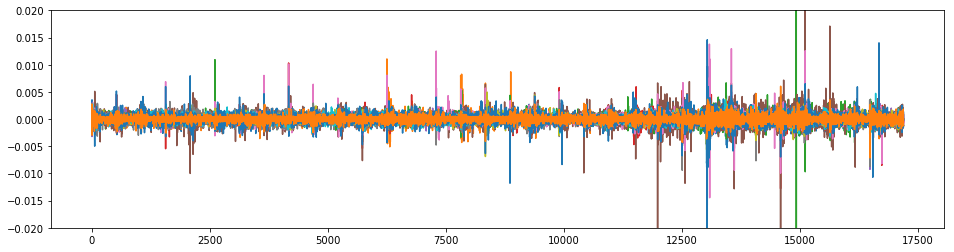

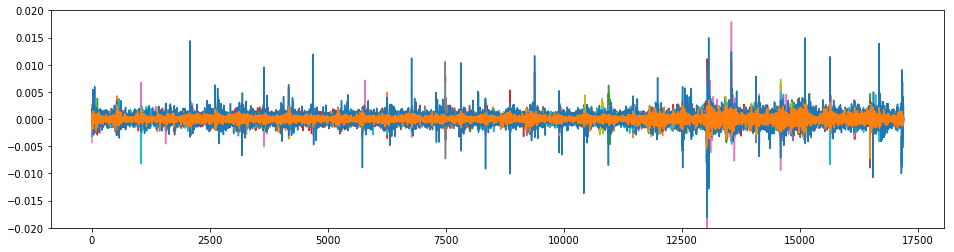

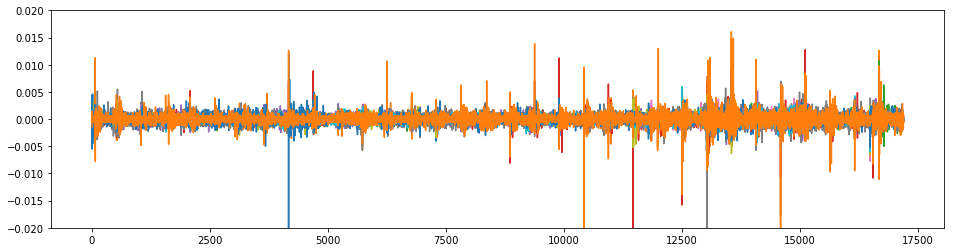

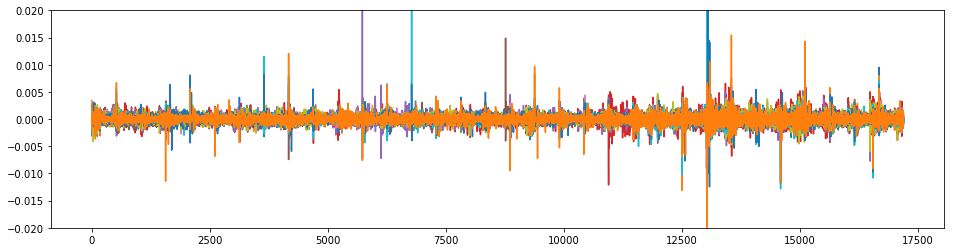

In [28]:
fig, ax = plt.subplots(figsize=[16, 4])
for d in np.linspace(0, 11, num=12, dtype=int):
    ax.plot(data[:,d])
    ax.axes.set_ylim(bottom=-.02, top=.02)

fig, ax = plt.subplots(figsize=[16, 4])
for d in np.linspace(12, 23, num=12, dtype=int):
    ax.plot(data[:,d])
    ax.axes.set_ylim(bottom=-.02, top=.02)
    
fig, ax = plt.subplots(figsize=[16, 4])
for d in np.linspace(24, 35, num=12, dtype=int):
    ax.plot(data[:,d])
    ax.axes.set_ylim(bottom=-.02, top=.02)
    
fig, ax = plt.subplots(figsize=[16, 4])
for d in np.linspace(36, 47, num=12, dtype=int):
    ax.plot(data[:,d])
    ax.axes.set_ylim(bottom=-.02, top=.02)

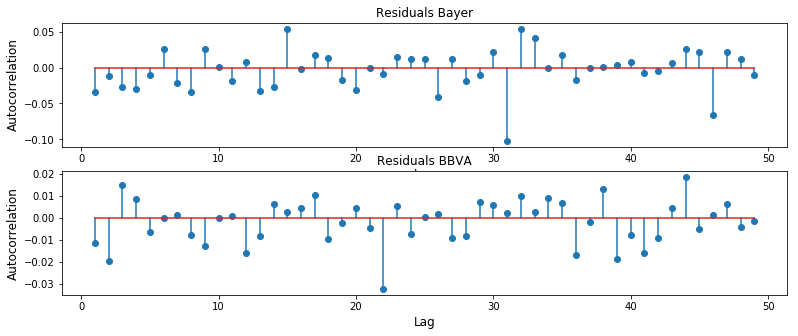

In [43]:
#plt.plot(df['BAYN GR Equity'].autocorr())
lags = range(1, 50)
autocorrs0 = [df['BAYN GR Equity'].autocorr(lag=lag) 
                   for lag in lags]
autocorrs1 = [df['BBVA SM Equity'].autocorr(lag=lag) 
                   for lag in lags]
plt.figure(figsize=(13, 5))
plt.subplot(211)
plt.stem(lags, autocorrs0)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title('Residuals Bayer')
plt.subplot(212)
plt.stem(lags, autocorrs1)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)
plt.title('Residuals BBVA')

## Apply Bayesian Changepoint to Residuals

1. Independent Factor Model
2. Full Covariance Model

In [61]:
data_ = data[:5000,:3]
data_.shape

(5000, 3)

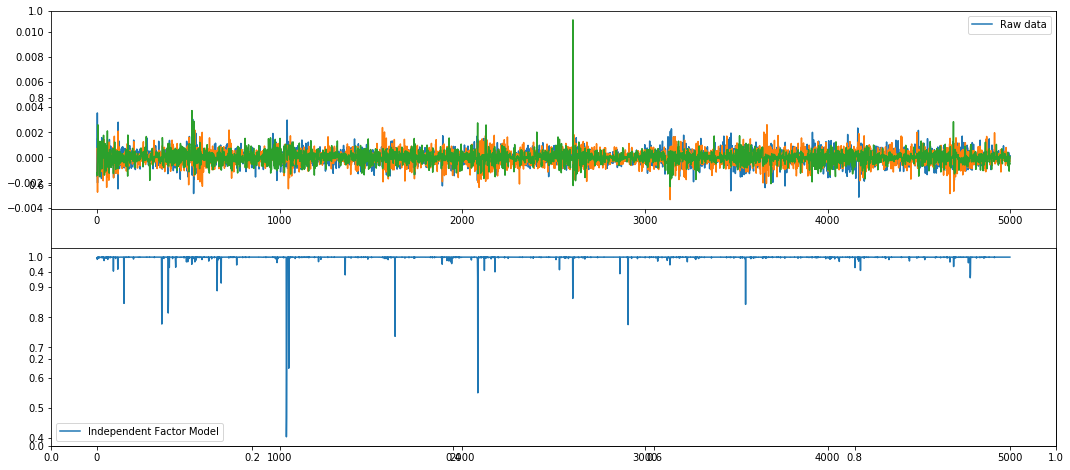

In [62]:
from functools import partial

Q_ifm, P_ifm, Pcp_ifm = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),ifm_obs_log_likelihood,truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for d in range(3):
    ax.plot(data_[:,d])
plt.legend(['Raw data'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_ifm).sum(0))
plt.legend(['Independent Factor Model'])
plt.show()

It looks like it is detecting some changepoints...

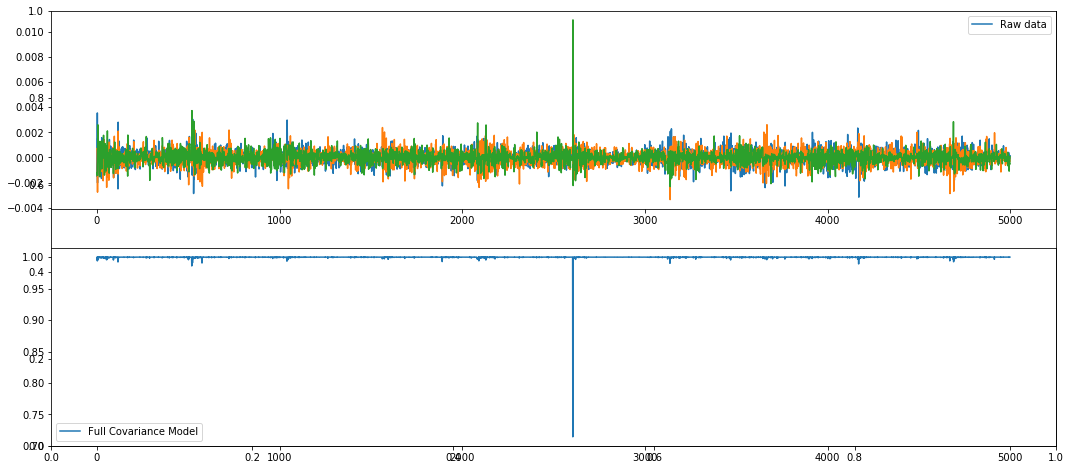

In [67]:
Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),fullcov_obs_log_likelihood, truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for d in range(3):
    ax.plot(data_[:,d])
plt.legend(['Raw data'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_full).sum(0))
plt.legend(['Full Covariance Model'])
plt.show()

Worst!!!

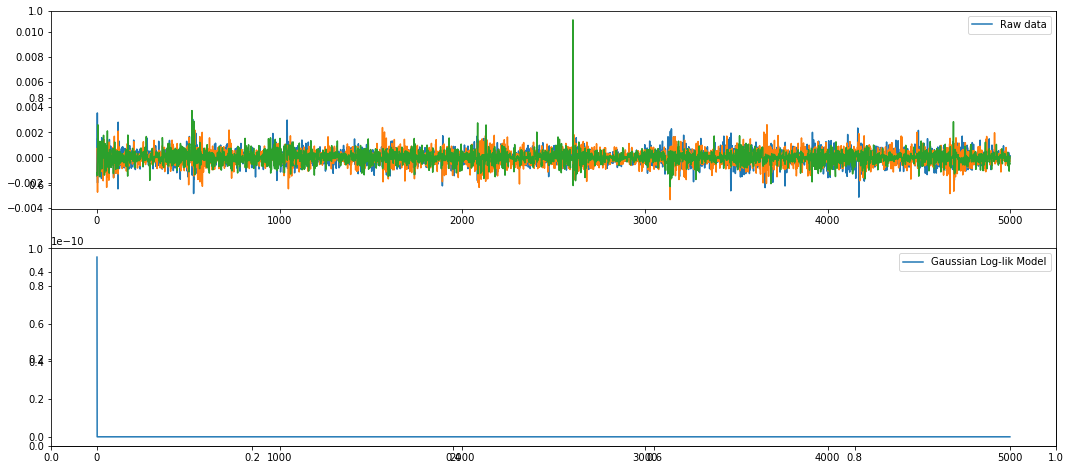

In [68]:
Q_gauss, P_gauss, Pcp_gauss = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),gaussian_obs_log_likelihood, truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for d in range(3):
    ax.plot(data_[:,d])
plt.legend(['Raw data'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_gauss).sum(0))
plt.legend(['Gaussian Log-lik Model'])
plt.show()

Not good!

In [86]:
data_ = data[:1000,:5]
data_.shape

(1000, 5)

5
6
7
8
9


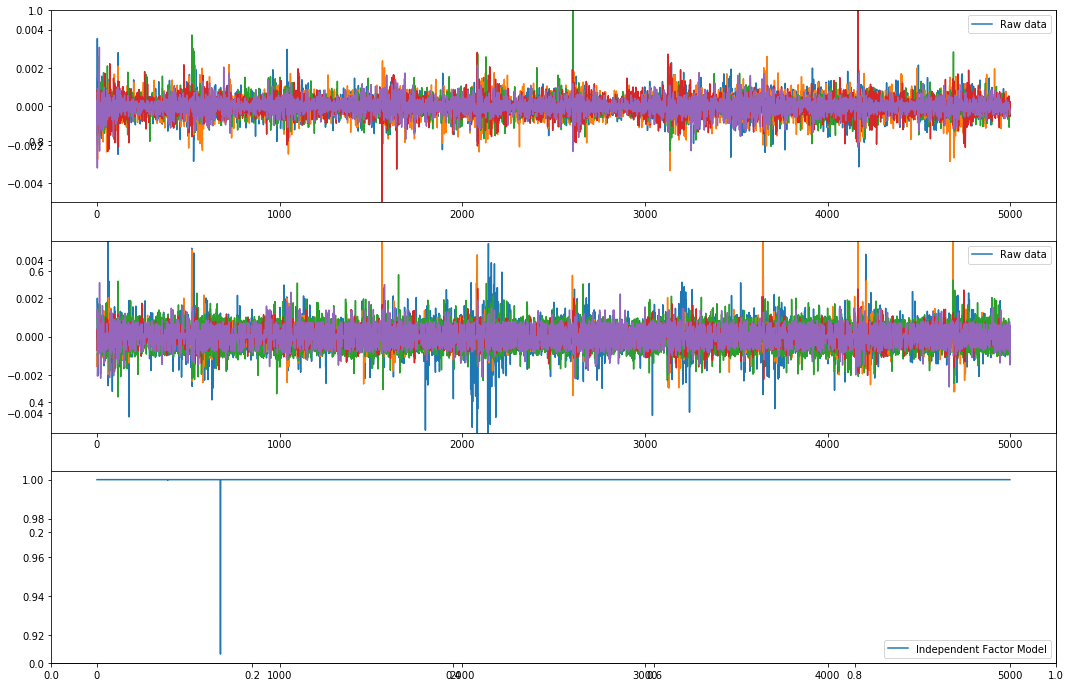

In [83]:
from functools import partial

Q_ifm, P_ifm, Pcp_ifm = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),ifm_obs_log_likelihood,truncate=-20)

fig, ax = plt.subplots(figsize=[18, 12])
ax = fig.add_subplot(3, 1, 1)
for d in range(5):
    ax.plot(data_[:,d])
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])

ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
    
ax = fig.add_subplot(3, 1, 3, sharex=ax)
ax.plot(np.exp(Pcp_ifm).sum(0))
plt.legend(['Independent Factor Model'])
plt.show()

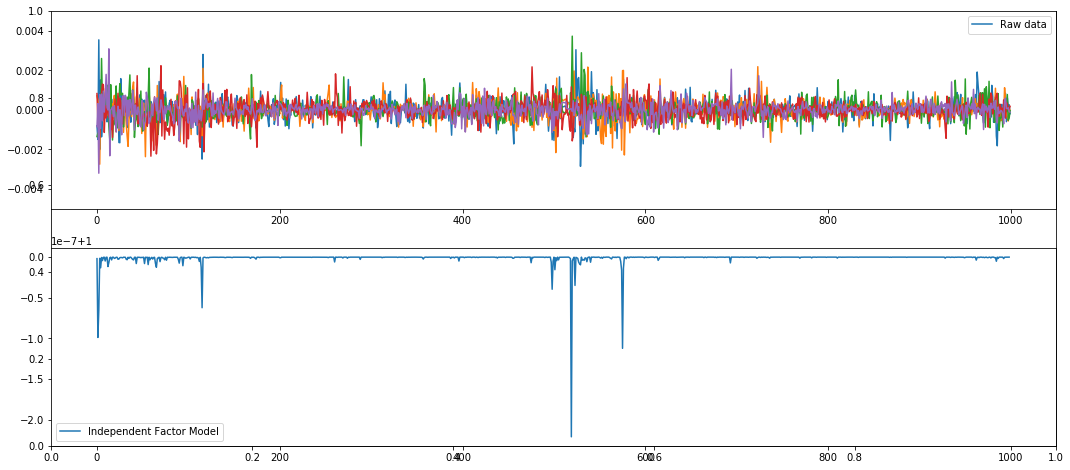

In [87]:
from functools import partial

Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),fullcov_obs_log_likelihood,truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for d in range(5):
    ax.plot(data_[:,d])
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])

'''ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
'''    
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_full).sum(0))
plt.legend(['Full Covariance Model'])
plt.show()

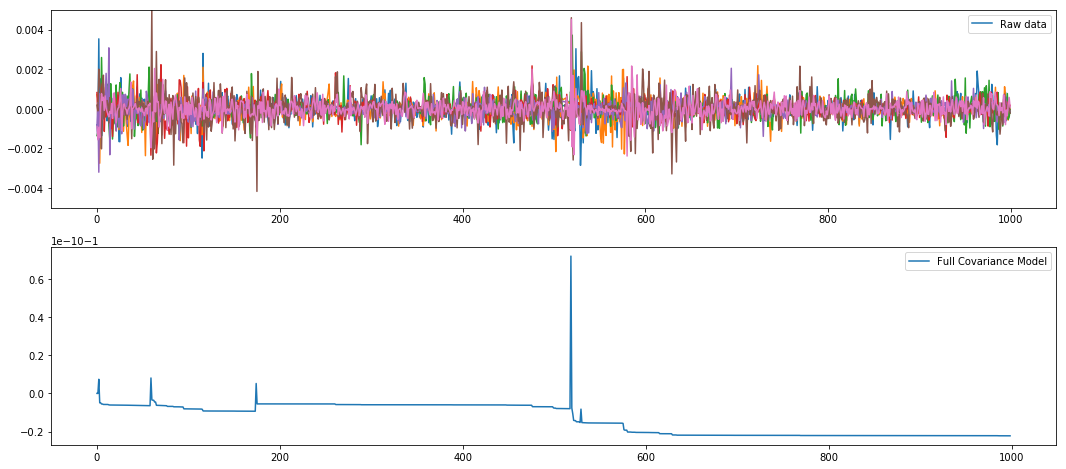

In [95]:
data_ = data[:1000,:7]

from functools import partial

Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),fullcov_obs_log_likelihood,truncate=-20)

plt.figure(figsize=(18, 8))
plt.subplot(211)
for d in range(7):
    plt.plot(data_[:,d])
    plt.ylim([-.005, .005])
plt.legend(['Raw data'])

'''ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
'''    
plt.subplot(212)
plt.plot(-np.exp(Pcp_full).sum(0))
plt.legend(['Full Covariance Model'])
plt.show()

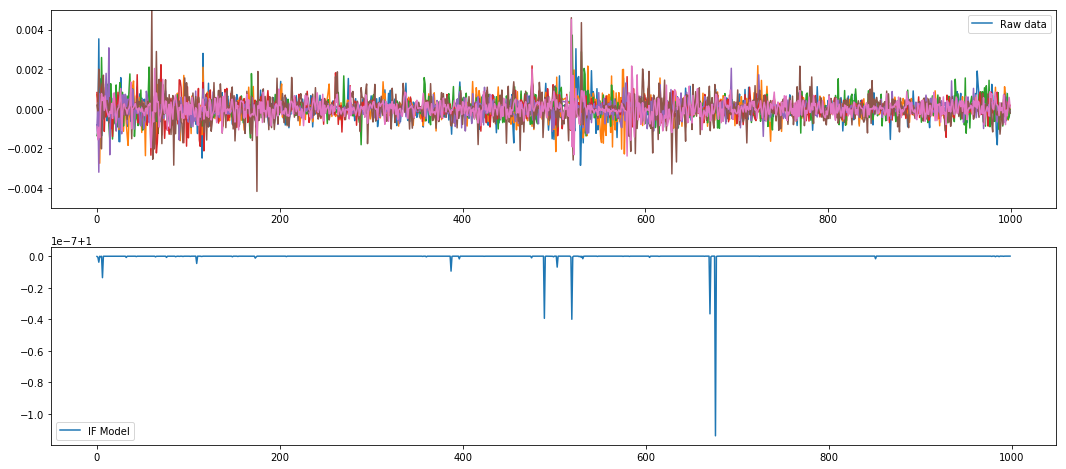

In [96]:
data_ = data[:1000,:7]

from functools import partial

Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),ifm_obs_log_likelihood,truncate=-20)

plt.figure(figsize=(18, 8))
plt.subplot(211)
for d in range(7):
    plt.plot(data_[:,d])
    plt.ylim([-.005, .005])
plt.legend(['Raw data'])

'''ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
'''    
plt.subplot(212)
plt.plot(np.exp(Pcp_full).sum(0))
plt.legend(['IF Model'])
plt.show()

In [100]:
data_ = data[12000:,[3,25]]
data_.shape

(5191, 2)

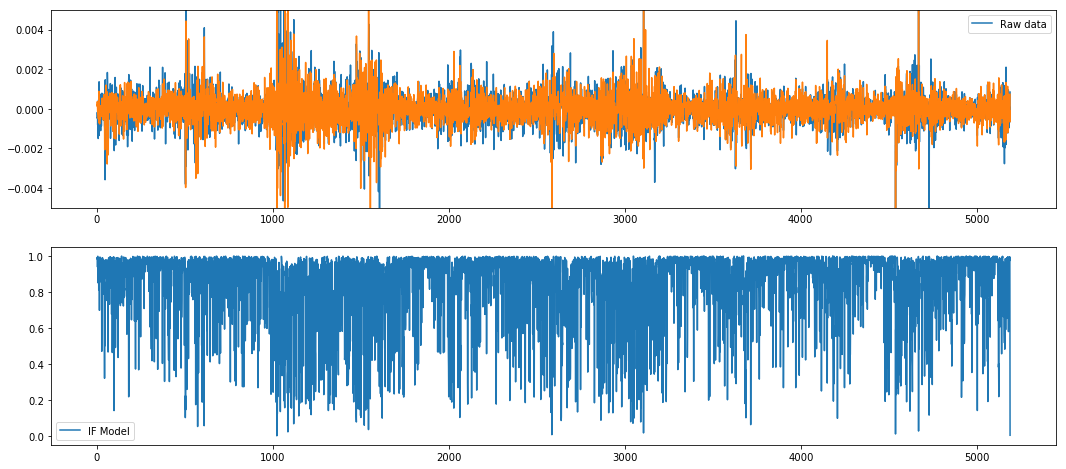

In [102]:
from functools import partial

Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),ifm_obs_log_likelihood,truncate=-20)

plt.figure(figsize=(18, 8))
plt.subplot(211)
for d in range(2):
    plt.plot(data_[:,d])
    plt.ylim([-.005, .005])
plt.legend(['Raw data'])

'''ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
'''    
plt.subplot(212)
plt.plot(np.exp(Pcp_full).sum(0))
plt.legend(['IF Model'])
plt.show()

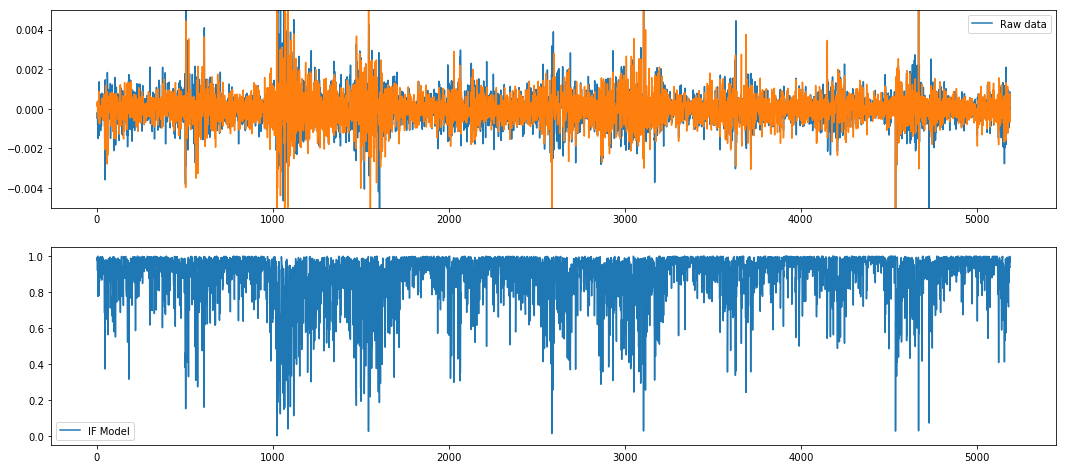

In [103]:
from functools import partial

Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),fullcov_obs_log_likelihood,truncate=-20)

plt.figure(figsize=(18, 8))
plt.subplot(211)
for d in range(2):
    plt.plot(data_[:,d])
    plt.ylim([-.005, .005])
plt.legend(['Raw data'])

'''ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
'''    
plt.subplot(212)
plt.plot(np.exp(Pcp_full).sum(0))
plt.legend(['IF Model'])
plt.show()

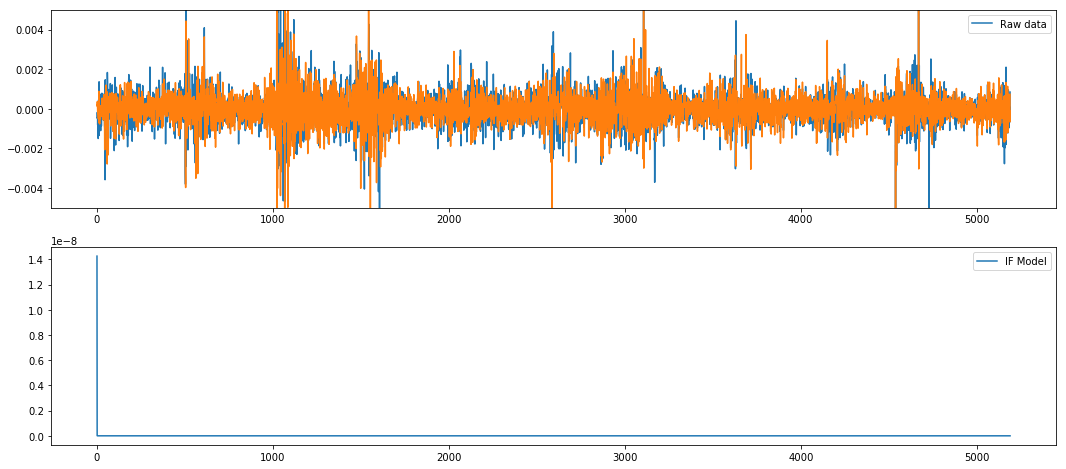

In [104]:
from functools import partial

Q_full, P_full, Pcp_full = offline_changepoint_detection(data_,partial(const_prior, l=(len(data_)+1)),gaussian_obs_log_likelihood,truncate=-20)

plt.figure(figsize=(18, 8))
plt.subplot(211)
for d in range(2):
    plt.plot(data_[:,d])
    plt.ylim([-.005, .005])
plt.legend(['Raw data'])

'''ax = fig.add_subplot(3, 1, 2, sharex=ax)
for d in range(5):
    ax.plot(data_[:,d+5])
    print(d+5)
    ax.axes.set_ylim(bottom=-.005, top=.005)
plt.legend(['Raw data'])
'''    
plt.subplot(212)
plt.plot(np.exp(Pcp_full).sum(0))
plt.legend(['IF Model'])
plt.show()

## Try online detection 

using T-student 

In [106]:
data__ = data[12000:,25]
data__.shape

(5191,)

In [107]:
R, maxes = online_changepoint_detection(data__, partial(constant_hazard, 250), StudentT(0.1, .01, 1, 0))

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


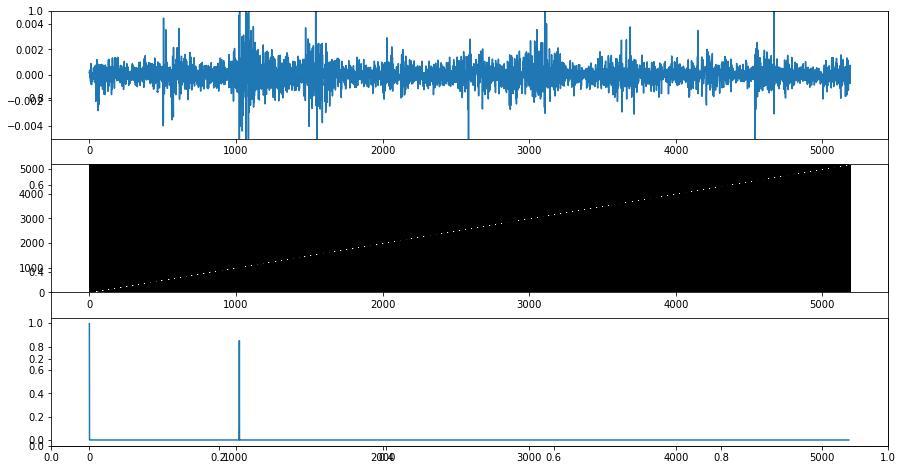

In [109]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[15, 8])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data__)
ax.axes.set_ylim(bottom=-.005, top=.005)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

In [110]:
Q, P, Pcp = offline_changepoint_detection(data__, partial(const_prior, l=(len(data__)+1)), gaussian_obs_log_likelihood, truncate=-40)

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=[15, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax.axes.set_ylim(bottom=-.005, top=.005)
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))

# Auxiliary functions needed to perform BCPA

In [44]:
from __future__ import division
import numpy as np
from scipy.special import gammaln, multigammaln
from scipy.misc import comb
from decorator import decorator

# This makes the code compatible with Python 3
# without causing performance hits on Python 2
try:
    xrange
except NameError:
    xrange = range


try:
    from sselogsumexp import logsumexp
except ImportError:
    from scipy.misc import logsumexp
    print("Use scipy logsumexp().")
else:
    print("Use SSE accelerated logsumexp().")


def _dynamic_programming(f, *args, **kwargs):
    if f.data is None:
        f.data = args[0]

    if not np.array_equal(f.data, args[0]):
        f.cache = {}
        f.data = args[0]

    try:
        f.cache[args[1:3]]
    except KeyError:
        f.cache[args[1:3]] = f(*args, **kwargs)
    return f.cache[args[1:3]]

def dynamic_programming(f):
    f.cache = {}
    f.data = None
    return decorator(_dynamic_programming, f)


def offline_changepoint_detection(data, prior_func,
                                  observation_log_likelihood_function,
                                  truncate=-np.inf):
    """Compute the likelihood of changepoints on data.
    Keyword arguments:
    data                                -- the time series data
    prior_func                          -- a function giving the likelihood of a changepoint given the distance to the last one
    observation_log_likelihood_function -- a function giving the log likelihood
                                           of a data part
    truncate                            -- the cutoff probability 10^truncate to stop computation for that changepoint log likelihood
    P                                   -- the likelihoods if pre-computed
    """

    n = len(data)
    Q = np.zeros((n,))
    g = np.zeros((n,))
    G = np.zeros((n,))
    P = np.ones((n, n)) * -np.inf

    # save everything in log representation
    for t in range(n):
        g[t] = np.log(prior_func(t))
        if t == 0:
            G[t] = g[t]
        else:
            '''Logarithm of the sum of exponentiations of the inputs.

            Calculates ``log(exp(x1) + exp(x2))``. This function is useful in
            statistics where the calculated probabilities of events may be so small
            as to exceed the range of normal floating point numbers.  In such cases
            the logarithm of the calculated probability is stored. This function
            allows adding probabilities stored in such a fashion.'''
            G[t] = np.logaddexp(G[t-1], g[t])

    P[n-1, n-1] = observation_log_likelihood_function(data, n-1, n)
    Q[n-1] = P[n-1, n-1]

    for t in reversed(range(n-1)):
        P_next_cp = -np.inf  # == log(0)
        for s in range(t, n-1):
            P[t, s] = observation_log_likelihood_function(data, t, s+1)

            # compute recursion
            summand = P[t, s] + Q[s + 1] + g[s + 1 - t]
            P_next_cp = np.logaddexp(P_next_cp, summand)

            # truncate sum to become approx. linear in time (see
            # Fearnhead, 2006, eq. (3))
            if summand - P_next_cp < truncate:
                break

        P[t, n-1] = observation_log_likelihood_function(data, t, n)

        # (1 - G) is numerical stable until G becomes numerically 1
        if G[n-1-t] < -1e-15:  # exp(-1e-15) = .99999...
            antiG = np.log(1 - np.exp(G[n-1-t]))
        else:
            # (1 - G) is approx. -log(G) for G close to 1
            antiG = np.log(-G[n-1-t])

        Q[t] = np.logaddexp(P_next_cp, P[t, n-1] + antiG)

    Pcp = np.ones((n-1, n-1)) * -np.inf
    for t in range(n-1):
        Pcp[0, t] = P[0, t] + Q[t + 1] + g[t] - Q[0]
        if np.isnan(Pcp[0, t]):
            Pcp[0, t] = -np.inf
    for j in range(1, n-1):
        for t in range(j, n-1):
            tmp_cond = Pcp[j-1, j-1:t] + P[j:t+1, t] + Q[t + 1] + g[0:t-j+1] - Q[j:t+1]
            Pcp[j, t] = logsumexp(tmp_cond.astype(np.float32))
            if np.isnan(Pcp[j, t]):
                Pcp[j, t] = -np.inf

    return Q, P, Pcp

@dynamic_programming
def gaussian_obs_log_likelihood(data, t, s):
    s += 1
    n = s - t
    mean = data[t:s].sum(0) / n

    muT = (n * mean) / (1 + n)
    nuT = 1 + n
    alphaT = 1 + n / 2
    betaT = 1 + 0.5 * ((data[t:s] - mean) ** 2).sum(0) + ((n)/(1 + n)) * (mean**2 / 2)
    scale = (betaT*(nuT + 1))/(alphaT * nuT)

    # splitting the PDF of the student distribution up is /much/ faster.
    # (~ factor 20) using sum over for loop is even more worthwhile
    prob = np.sum(np.log(1 + (data[t:s] - muT)**2/(nuT * scale)))
    lgA = gammaln((nuT + 1) / 2) - np.log(np.sqrt(np.pi * nuT * scale)) - gammaln(nuT/2)

    return np.sum(n * lgA - (nuT + 1)/2 * prob)

def ifm_obs_log_likelihood(data, t, s):
    '''Independent Features model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        d = x.shape[1]
    else:
        d = 1
        x = np.atleast_2d(x).T

    N0 = d          # weakest prior we can use to retain proper prior
    V0 = np.var(x)
    Vn = V0 + (x**2).sum(0)

    # sum over dimension and return (section 3.1 from Xuan paper):
    return d*( -(n/2)*np.log(np.pi) + (N0/2)*np.log(V0) - \
        gammaln(N0/2) + gammaln((N0+n)/2) ) - \
        ( ((N0+n)/2)*np.log(Vn) ).sum(0)

def fullcov_obs_log_likelihood(data, t, s):
    '''Full Covariance model from xuan et al'''
    s += 1
    n = s - t
    x = data[t:s]
    if len(x.shape)==2:
        dim = x.shape[1]
    else:
        dim = 1
        x = np.atleast_2d(x).T

    N0 = dim          # weakest prior we can use to retain proper prior
    V0 = np.var(x)*np.eye(dim)
    
    # Improvement over np.outer
    # http://stackoverflow.com/questions/17437523/python-fast-way-to-sum-outer-products
    # Vn = V0 + np.array([np.outer(x[i], x[i].T) for i in xrange(x.shape[0])]).sum(0)
    Vn = V0 + np.einsum('ij,ik->jk', x, x)

    # section 3.2 from Xuan paper:
    return -(dim*n/2)*np.log(np.pi) + (N0/2)*np.linalg.slogdet(V0)[1] - \
        multigammaln(N0/2,dim) + multigammaln((N0+n)/2,dim) - \
        ((N0+n)/2)*np.linalg.slogdet(Vn)[1]

def const_prior(r, l):
    return 1/(l)

def geometric_prior(t, p):
    return p * ((1 - p) ** (t - 1))

def neg_binominal_prior(t, k, p):
    return comb(t - k, k - 1) * p ** k * (1 - p) ** (t - k)

Use scipy logsumexp().


In [105]:
from __future__ import division
import numpy as np
from scipy import stats

def online_changepoint_detection(data, hazard_func, observation_likelihood):
    maxes = np.zeros(len(data) + 1)
    
    R = np.zeros((len(data) + 1, len(data) + 1))
    R[0, 0] = 1
    
    for t, x in enumerate(data):
        # Evaluate the predictive distribution for the new datum under each of
        # the parameters.  This is the standard thing from Bayesian inference.
        predprobs = observation_likelihood.pdf(x)
        
        # Evaluate the hazard function for this interval
        H = hazard_func(np.array(range(t+1)))
       
        # Evaluate the growth probabilities - shift the probabilities down and to
        # the right, scaled by the hazard function and the predictive
        # probabilities.
        R[1:t+2, t+1] = R[0:t+1, t] * predprobs * (1-H)
        
        # Evaluate the probability that there *was* a changepoint and we're
        # accumulating the mass back down at r = 0.
        R[0, t+1] = np.sum( R[0:t+1, t] * predprobs * H)
        
        # Renormalize the run length probabilities for improved numerical
        # stability.
        R[:, t+1] = R[:, t+1] / np.sum(R[:, t+1])
        
        # Update the parameter sets for each possible run length.
        observation_likelihood.update_theta(x)
    
        maxes[t] = R[:, t].argmax()
    return R, maxes


def constant_hazard(lam, r):
    return 1/lam * np.ones(r.shape)


class StudentT:
    def __init__(self, alpha, beta, kappa, mu):
        self.alpha0 = self.alpha = np.array([alpha])
        self.beta0 = self.beta = np.array([beta])
        self.kappa0 = self.kappa = np.array([kappa])
        self.mu0 = self.mu = np.array([mu])

    def pdf(self, data):
        return stats.t.pdf(x=data, 
                           df=2*self.alpha,
                           loc=self.mu,
                           scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha *
                               self.kappa)))

    def update_theta(self, data):
        muT0 = np.concatenate((self.mu0, (self.kappa * self.mu + data) / (self.kappa + 1)))
        kappaT0 = np.concatenate((self.kappa0, self.kappa + 1.))
        alphaT0 = np.concatenate((self.alpha0, self.alpha + 0.5))
        betaT0 = np.concatenate((self.beta0, self.beta + (self.kappa * (data -
            self.mu)**2) / (2. * (self.kappa + 1.))))
            
        self.mu = muT0
        self.kappa = kappaT0
        self.alpha = alphaT0
        self.beta = betaT0